# Predicting FPS in games based on your hardware
This is the notebook where I will prepare and explore data and build prediction model.

## Imports, data loading, first look

In [1]:
! pip install phik
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 696 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 24 kB/s 


In [2]:
from scipy.io.arff import loadarff

import pandas as pd
import numpy as np
import statistics as stat
import pickle
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [3]:
%%time
df = pd.DataFrame(loadarff('/content/drive/MyDrive/Datasets/fps-in-video-games.arff')[0])

CPU times: user 18.9 s, sys: 1.26 s, total: 20.2 s
Wall time: 24.5 s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425833 entries, 0 to 425832
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CpuName                    425833 non-null  object 
 1   CpuNumberOfCores           425833 non-null  float64
 2   CpuNumberOfThreads         425833 non-null  float64
 3   CpuBaseClock               425833 non-null  float64
 4   CpuCacheL1                 425833 non-null  float64
 5   CpuCacheL2                 425833 non-null  float64
 6   CpuCacheL3                 420778 non-null  float64
 7   CpuDieSize                 223299 non-null  float64
 8   CpuFrequency               425833 non-null  float64
 9   CpuMultiplier              425833 non-null  float64
 10  CpuMultiplierUnlocked      425833 non-null  object 
 11  CpuProcessSize             425833 non-null  float64
 12  CpuTDP                     425833 non-null  float64
 13  CpuNumberOfTransistors     19

Initially, the model was trained on all data, but due to the low quality of the model, I decided to remove data from the userbenchmark source from the dataset.  After that, the quality of the model has increased significantly.

In [5]:
df['Dataset'] = [i.decode('utf-8') for i in df['Dataset']]

In [6]:
df['Dataset'].unique()

array(['userbenchmark', 'fpsbenchmark'], dtype=object)

In [7]:
df = df[df['Dataset'] == 'fpsbenchmark']

## Data preparation

### Correlation Check

In [8]:
%%time
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock', 'CpuCacheL1', 'CpuCacheL2', 'CpuCacheL3', 'CpuDieSize', 'CpuFrequency', 'CpuMultiplier', 'CpuProcessSize', 'CpuTDP', 'CpuNumberOfTransistors', 'CpuTurboClock', 'GpuBandwidth', 'GpuBaseClock', 'GpuBoostClock', 'GpuNumberOfComputeUnits', 'GpuDieSize', 'GpuNumberOfExecutionUnits', 'GpuFP32Performance', 'GpuMemoryBus', 'GpuMemorySize', 'GpuPixelRate', 'GpuProcessSize', 'GpuNumberOfROPs', 'GpuNumberOfShadingUnits', 'GpuNumberOfTMUs', 'GpuTextureRate', 'GpuNumberOfTransistors', 'GameResolution', 'FPS']


/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable CpuBaseClock for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable GpuNumberOfExecutionUnits for analysis 0. Dropping this column
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable GameResolution for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Dataset for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable GpuOpenGL for analysis 1. Dropping this column
  warnings.warn(


CPU times: user 4.7 s, sys: 895 ms, total: 5.59 s
Wall time: 10.9 s


CPU times: user 2.1 s, sys: 226 ms, total: 2.33 s
Wall time: 2.26 s


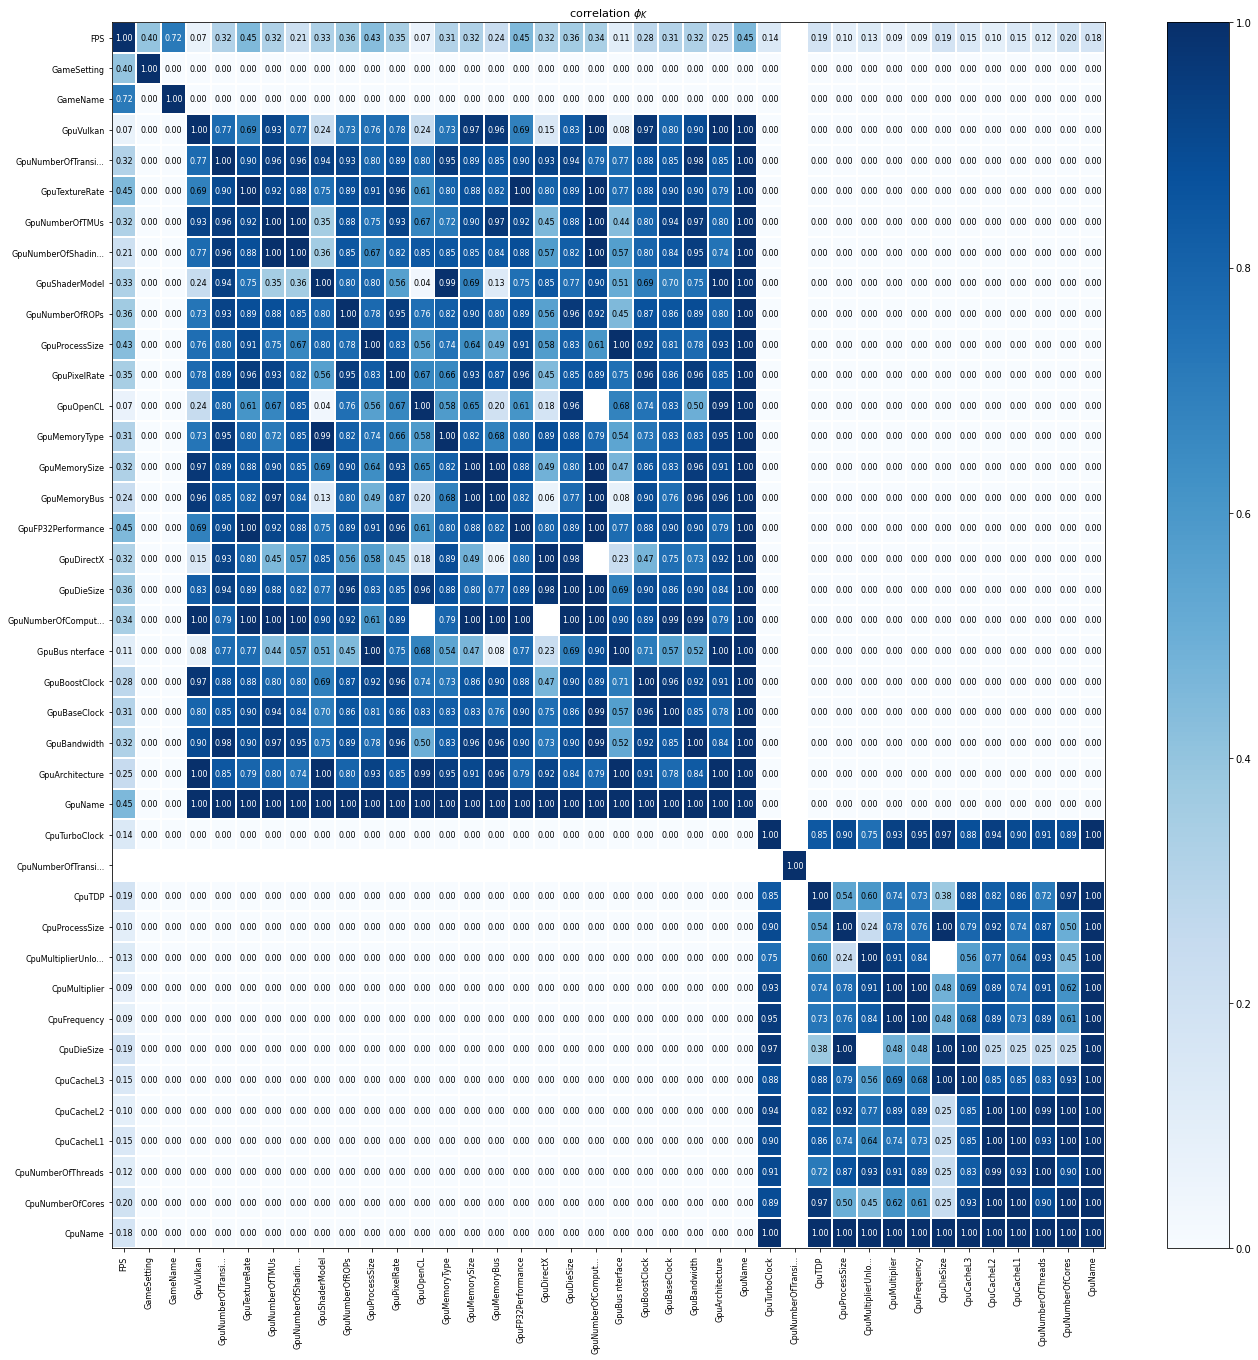

In [9]:
%%time

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(19, 19))
plt.tight_layout()


In [10]:
del phik_overview

There is strong correlation between Hardware names and its specifications. So we can delete all of specifications. Also now we have only one resolution, let's remove this column. New dataset will include only CPU, GPU names, game name, game setting and FPS.

In [11]:
df = df[['CpuName', 'GpuName', 'GameName', 'GameSetting', 'FPS']]

Let's fix columns names

In [12]:
df.columns = ['cpu_name', 'gpu_name', 'game_name', 'game_setting','fps']

Now we need check if we have some missing values

In [13]:
df.isna().mean()

cpu_name        0.0
gpu_name        0.0
game_name       0.0
game_setting    0.0
fps             0.0
dtype: float64

Let's define `cat_features`

In [14]:
cat_features = ['cpu_name', 'gpu_name', 'game_name', 'game_setting']

In [15]:
df.describe()

,fps
count,24624.000000
mean,123.959369
std,54.610080
min,22.200000
25%,83.600000
50%,114.300000
75%,154.100000
max,396.400000


In [16]:
df.sample(3)

,cpu_name,gpu_name,game_name,game_setting,fps
407539,b'Intel Core i7-7700K',b'NVIDIA GeForce GTX 1070 Ti',b'overwatch',b'med',189.8
415322,b'AMD Ryzen 5 2600X',b'NVIDIA GeForce GTX 980 Ti',b'leagueOfLegends',b'max',182.3
407811,b'Intel Core i3-7100',b'AMD Radeon Pro Vega 64',b'overwatch',b'med',142.5


Fixin `b'...'`

In [17]:
for col in cat_features:
  df[col] = [i.decode('utf-8') for i in df[col]]
del col

<ipython-input-17-ea74ab4a7b90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = [i.decode('utf-8') for i in df[col]]


In [18]:
df.sample(3)

,cpu_name,gpu_name,game_name,game_setting,fps
413733,Intel Core i7-7700K,NVIDIA GeForce GTX 1660 Ti,airMechStrike,med,143.9
414952,Intel Core i5-8400,AMD Radeon RX 5700 XT,worldOfTanks,med,82.4
416046,AMD Ryzen 5 2600,AMD Radeon RX 590,farCry5,med,105.2


Fixing games names.



In [19]:
df['game_name'].unique()

array(['callOfDutyWW2', 'fortnite', 'pathOfExile', 'destiny2',
       'radicalHeights', 'leagueOfLegends', 'overwatch',
       'playerUnknownsBattlegrounds', 'dota2',
       'counterStrikeGlobalOffensive', 'seaOfThieves', 'apexLegends',
       'frostpunk', 'totalWar3Kingdoms', 'worldOfTanks', 'battlefield4',
       'warframe', 'airMechStrike', 'battletech', 'farCry5', 'starcraft2',
       'rainbowSixSiege', 'grandTheftAuto5', 'aWayOut'], dtype=object)

In [20]:
df['game_name'] = df['game_name'].replace(
    ['callOfDutyWW2', 'fortnite', 'pathOfExile', 'destiny2',
       'radicalHeights', 'leagueOfLegends', 'overwatch',
       'playerUnknownsBattlegrounds', 'dota2',
       'counterStrikeGlobalOffensive', 'seaOfThieves', 'apexLegends',
       'frostpunk', 'totalWar3Kingdoms', 'worldOfTanks', 'battlefield4',
       'warframe', 'airMechStrike', 'battletech', 'farCry5', 'starcraft2',
       'rainbowSixSiege', 'grandTheftAuto5', 'aWayOut'], 
       
       ['Call Of Duty WW2', 'Fortnite', 'Path Of Exile', 'Destiny 2',
       'Radical Heights', 'League Of Legends', 'Overwatch',
       'Player Unknowns Battlegrounds', 'Dota 2',
       'Counter Strike GO', 'Sea Of Thieves', 'Apex Legends',
       'Frostpunk', 'Total War 3 Kingdoms', 'World Of Tanks', 'Battlefield 4',
       'Warframe', 'Air Mech Strike', 'Battletech', 'Far Cry 5', 'Starcraft 2',
       'Rainbow Six Siege', 'Grand Theft Auto 5', 'A Way Out'])

### Removing outliers

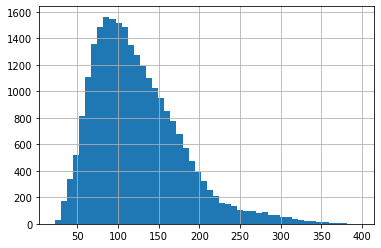

In [21]:
df.fps.hist(bins=50)

There's no need to fix it

## Model training

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24624 entries, 401209 to 425832
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cpu_name      24624 non-null  object 
 1   gpu_name      24624 non-null  object 
 2   game_name     24624 non-null  object 
 3   game_setting  24624 non-null  object 
 4   fps           24624 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


Let's get params for our model

In [23]:
%%time
y = ['fps']
X = ['cpu_name', 'gpu_name', 'game_name', 'game_setting']

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.25, random_state=80)

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 200,
    'random_seed': 171022,
    'cat_features': cat_features,
    'iterations': 1000,
}
model = CatBoostRegressor(**params)
grid = {'learning_rate': [0.29, 0.3, 0.31], 'depth': [7, 8, 9], }
grid_search_result = model.grid_search(grid, X=X_train, y=y_train)




0:	learn: 102.8504444	test: 104.6322492	best: 104.6322492 (0)	total: 58.3ms	remaining: 58.3s
200:	learn: 6.0284570	test: 3.7708673	best: 3.7673667 (198)	total: 1.85s	remaining: 7.34s
400:	learn: 4.7452048	test: 3.3682069	best: 3.3659832 (397)	total: 3.56s	remaining: 5.32s
600:	learn: 4.0223450	test: 3.2581396	best: 3.2581396 (600)	total: 5.28s	remaining: 3.51s
800:	learn: 3.5836092	test: 3.2206031	best: 3.2171158 (746)	total: 6.99s	remaining: 1.74s
999:	learn: 3.2511211	test: 3.2026274	best: 3.2021471 (977)	total: 8.79s	remaining: 0us

bestTest = 3.20214707
bestIteration = 977

0:	loss: 3.2021471	best: 3.2021471 (0)	total: 8.86s	remaining: 1m 10s
0:	learn: 101.7744667	test: 103.5565430	best: 103.5565430 (0)	total: 5.55ms	remaining: 5.55s
200:	learn: 5.9442111	test: 3.7739806	best: 3.7675690 (193)	total: 1.75s	remaining: 6.94s
400:	learn: 4.6658922	test: 3.3830524	best: 3.3830524 (400)	total: 3.49s	remaining: 5.21s
600:	learn: 3.9131568	test: 3.2547004	best: 3.2487971 (595)	total: 5.2s	

In [24]:
params = model.get_params()
params

{'iterations': 1000,
 'loss_function': 'RMSE',
 'random_seed': 171022,
 'verbose': 200,
 'eval_metric': 'RMSE',
 'cat_features': ['cpu_name', 'gpu_name', 'game_name', 'game_setting'],
 'depth': 8,
 'learning_rate': 0.3}

In [25]:
min(grid_search_result['cv_results']['test-RMSE-mean'])

3.6839279586036446

Validation on test data

In [26]:
mean_squared_error(y_test, model.predict(X_test))**0.5

3.3001835226401397

Training on full dataset and saving model

In [27]:
model = CatBoostRegressor(**params)
model.fit(df[X], df[y])
pickle.dump(model, open('model.pkt', 'wb'))

0:	learn: 40.7901348	total: 20.5ms	remaining: 20.5s
200:	learn: 5.7990834	total: 2.83s	remaining: 11.3s
400:	learn: 5.0312089	total: 5.64s	remaining: 8.43s
600:	learn: 4.5684600	total: 8.41s	remaining: 5.58s
800:	learn: 4.2594448	total: 11.2s	remaining: 2.77s
999:	learn: 4.0398423	total: 13.9s	remaining: 0us
